In [59]:
import numpy as np

# Input Parameters
AmeEurFlag = 'a'  # 'a' for American, 'e' for European
CallPutFlag = 'p'  # 'c' for Call, 'p' for Put
S = 100            # Initial stock price
X = 110            # Strike price
T = 0.5            # Time to maturity (in years)
r = 0.1            # Risk-free interest rate
b = 0.1            # Cost of carry
sigma = 0.27       # Volatility
N = 30             # Number of time steps

# Derived parameters
q = b - r  # Convenience yield
z = 1 if CallPutFlag == 'c' else -1  # Call or Put flag multiplier

dt = T / N  # Time step
u = np.exp(sigma * np.sqrt(2 * dt))  # Up factor
d = np.exp(-sigma * np.sqrt(2 * dt))  # Down factor

# Risk-neutral probabilities
sqrt_dt_half = np.sqrt(dt / 2)
pu = ((np.exp(b * dt / 2) - np.exp(-sigma * sqrt_dt_half)) /
      (np.exp(sigma * sqrt_dt_half) - np.exp(-sigma * sqrt_dt_half))) ** 2
pd = ((np.exp(sigma * sqrt_dt_half) - np.exp(b * dt / 2)) /
      (np.exp(sigma * sqrt_dt_half) - np.exp(-sigma * sqrt_dt_half))) ** 2
pm = 1 - pu - pd  # Middle probability

Df = np.exp(-r * dt)  # Discount factor

# Initialize option value array
OptionValue = np.zeros(2 * N + 1)

# Terminal payoffs
for i in range(2 * N + 1):
    up_steps = max(i - N, 0)
    down_steps = max(N - i, 0)
    ST = S * u ** up_steps * d ** down_steps  # Stock price at node
    OptionValue[i] = max(0, z * (ST - X))    # Payoff at terminal node

# Backward induction for option valuation
for j in range(N - 1, -1, -1):
    for i in range(2 * j + 1):
        # Calculate continuation value
        OptionValue[i] = (pu * OptionValue[i + 2] +
                          pm * OptionValue[i + 1] +
                          pd * OptionValue[i]) * Df
        # If American, consider early exercise
        if AmeEurFlag == 'a':
            up_steps = max(i - j, 0)
            down_steps = max(j - i, 0)
            StockPrice = S * u ** up_steps * d ** down_steps
            OptionValue[i] = max(z * (StockPrice - X), OptionValue[i])

# Output the option price
print(OptionValue[0])


11.649312921905306


In [60]:
import numpy as np

def binomial_option_pricing(AmeEurFlag, CallPutFlag, S, X, T, r, b, sigma, N):
    
    # Derived parameters
    q = b - r  # Convenience yield
    z = 1 if CallPutFlag == 'c' else -1  # Call or Put flag multiplier

    dt = T / N  # Time step
    u = np.exp(sigma * np.sqrt(2 * dt))  # Up factor
    d = np.exp(-sigma * np.sqrt(2 * dt))  # Down factor

    # Risk-neutral probabilities
    sqrt_dt_half = np.sqrt(dt / 2)
    pu = ((np.exp(b * dt / 2) - np.exp(-sigma * sqrt_dt_half)) /
          (np.exp(sigma * sqrt_dt_half) - np.exp(-sigma * sqrt_dt_half))) ** 2
    pd = ((np.exp(sigma * sqrt_dt_half) - np.exp(b * dt / 2)) /
          (np.exp(sigma * sqrt_dt_half) - np.exp(-sigma * sqrt_dt_half))) ** 2
    pm = 1 - pu - pd  # Middle probability

    Df = np.exp(-r * dt)  # Discount factor

    # Initialize option value array
    OptionValue = np.zeros(2 * N + 1)

    # Terminal payoffs
    for i in range(2 * N + 1):
        up_steps = max(i - N, 0)
        down_steps = max(N - i, 0)
        StockPrice = S * u ** up_steps * d ** down_steps  # Stock price at node
        OptionValue[i] = max(0, z * (StockPrice - X))    # Payoff at terminal node

    # Backward induction for option valuation
    for j in range(N - 1, -1, -1):
        for i in range(2 * j + 1):
            # Calculate continuation value
            OptionValue[i] = (pu * OptionValue[i + 2] +
                              pm * OptionValue[i + 1] +
                              pd * OptionValue[i]) * Df
            # If American, consider early exercise
            if AmeEurFlag == 'a':
                up_steps = max(i - j, 0)
                down_steps = max(j - i, 0)
                StockPrice = S * u ** up_steps * d ** down_steps
                OptionValue[i] = max(z * (StockPrice - X), OptionValue[i])

    # Return the option price
    return OptionValue[0]

AmeEurFlag = 'a'
CallPutFlag = 'p'
S = 100
X = 110
T = 0.5
r = 0.1
b = 0.1
sigma = 0.27
N = 30

option_price = binomial_option_pricing(AmeEurFlag, CallPutFlag, S, X, T, r, b, sigma, N)
print(option_price)


11.649312921905306


In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [62]:
import numpy as np

def trinomial_convertible_bond(S0, F, T, r, b, sigma, coupon, conversion_ratio, N, AmeEurFlag='e'):
    dt = T / N  # Time step
    u = np.exp(sigma * np.sqrt(2 * dt))  # Up factor
    d = np.exp(-sigma * np.sqrt(2 * dt))  # Down factor
    pu = ((np.exp(b * dt / 2) - d) / (u - d)) ** 2  # Probability of upward movement
    pd = ((u - np.exp(b * dt / 2)) / (u - d)) ** 2  # Probability of downward movement
    pm = 1 - pu - pd  # Probability of no movement
    Df = np.exp(-r * dt)  # Discount factor

    # Initialize stock price tree
    StockPrice = np.zeros((2 * N + 1, N + 1))
    for i in range(N + 1):
        for j in range(2 * i + 1):
            StockPrice[j, i] = S0 * (u ** max(0, j - i)) * (d ** max(0, i - j))

    # Initialize bond price tree
    BondPrice = np.zeros((2 * N + 1, N + 1))

    # Terminal bond values
    for j in range(2 * N + 1):
        stock_price = StockPrice[j, N]
        conversion_value = conversion_ratio * stock_price
        bond_value_at_maturity = max(F + coupon, conversion_value)
        BondPrice[j, N] = bond_value_at_maturity

    # Backward induction
    for i in range(N - 1, -1, -1):
        for j in range(2 * i + 1):
            # Stock price at current node
            stock_price = StockPrice[j, i]

            # Bond value by holding (continuation value)
            continuation_value = (pu * BondPrice[j + 2, i + 1] +
                                  pm * BondPrice[j + 1, i + 1] +
                                  pd * BondPrice[j, i + 1]) * Df

            # Conversion value
            conversion_value = conversion_ratio * stock_price

            # Bond value at current node
            if AmeEurFlag == 'a':
                # American-style: Allow early conversion
                BondPrice[j, i] = max(continuation_value, conversion_value)
            else:
                # European-style: Only allow conversion at maturity
                BondPrice[j, i] = continuation_value

    # The value of the bond at the root node (time 0)
    return BondPrice[0, 0]

# Example parameters
S0 = 100           # Initial stock price
F = 110            # Face value of the bond
T = 0.5            # Time to maturity (years)
r = 0.1            # Risk-free rate
b = 0.1            # Cost of carry
sigma = 0.27       # Volatility
coupon = 5         # Annual coupon payment
conversion_ratio = 1.2  # Conversion ratio
N = 30             # Number of time steps
AmeEurFlag = 'a'   # 'a' for American, 'e' for European

# Calculate convertible bond value
bond_price = trinomial_convertible_bond(S0, F, T, r, b, sigma, coupon, conversion_ratio, N, AmeEurFlag)
print(f"Convertible Bond Price: {bond_price:.4f}")


Convertible Bond Price: 122.1466


In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [35]:
S0 = 100            # Initial stock price
F = 110             # Face value of the bond
T = 0.5             # Time to maturity
r = 0.1             # Risk-free rate
k = 0.02            # Spread over risk-free rate
coupon = 5          # Annual coupon payment
conversion_ratio = 1.2  # Conversion ratio
N = 30              # Number of time steps
sigma = 0.27        # Volatility
AmeEur = 'a'        # 'a' for American, 'e' for European

def TrinomialConvBond(S0, F, T, r, k, coupon, conversion_ratio, N, sigma, AmeEur='e'):
    dt = T / N  # Time step
    u = np.exp(sigma * np.sqrt(2 * dt))  # Up factor
    d = np.exp(-sigma * np.sqrt(2 * dt))  # Down factor

    # Risk-neutral probabilities
    sqrt_dt_half = np.sqrt(dt / 2)
    pu = ((np.exp(r * dt / 2) - d) / (u - d)) ** 2  # Probability of upward movement
    pd = ((u - np.exp(r * dt / 2)) / (u - d)) ** 2  # Probability of downward movement
    pm = 1 - pu - pd  # Probability of no movement

    # Discount factors
    Df = np.exp(-r * dt)  # Risk-free discount factor per step
    
    # Initialize stock price tree
    StockPrice = np.zeros((2 * N + 1, N + 1))
    for i in range(N + 1):
        for j in range(2 * i + 1):
            StockPrice[j, i] = S0 * (u ** max(0, j - i)) * (d ** max(0, i - j))

    # Initialize bond price tree and conversion probability tree
    BondPrice = np.zeros((2 * N + 1, N + 1))
    ConversionProbability = np.zeros((2 * N + 1, N + 1))

    # Terminal bond values
    for j in range(2 * N + 1):
        stock_price = StockPrice[j, N]
        conversion_value = conversion_ratio * stock_price
        bond_value_at_maturity = max(F + coupon, conversion_value)
        BondPrice[j, N] = bond_value_at_maturity
        ConversionProbability[j, N] = 1 if conversion_value > F else 0

    # Backward induction for bond price and conversion probability
    for i in range(N - 1, -1, -1):
        for j in range(2 * i + 1):
            stock_price = StockPrice[j, i]

            # Bond value if held (continuation value)
            continuation_value = (pu * BondPrice[j + 2, i + 1] + pm * BondPrice[j + 1, i + 1] + pd * BondPrice[j, i + 1]) * Df

            # Conversion value
            conversion_value = conversion_ratio * stock_price

            # Bond price at current node
            if AmeEur == 'a':  # American-style
                BondPrice[j, i] = max(continuation_value, conversion_value)
            else:  # European-style
                BondPrice[j, i] = continuation_value

            # Conversion probability
            if BondPrice[j, i] == conversion_value and AmeEur == 'a':
                ConversionProbability[j, i] = 1
            else:
                ConversionProbability[j, i] = (pu * ConversionProbability[j + 2, i + 1] +
                                                pm * ConversionProbability[j + 1, i + 1] +
                                                pd * ConversionProbability[j, i + 1])

    return StockPrice, BondPrice, ConversionProbability

# Calculate trinomial trees
StockPrice, BondPrice, ConversionProbability = TrinomialConvBond(
    S0, F, T, r, k, coupon, conversion_ratio, N, sigma, AmeEur)

In [36]:
print(f"Convertible Bond Price: {BondPrice[0, 0]:.4f}")

Convertible Bond Price: 122.1466


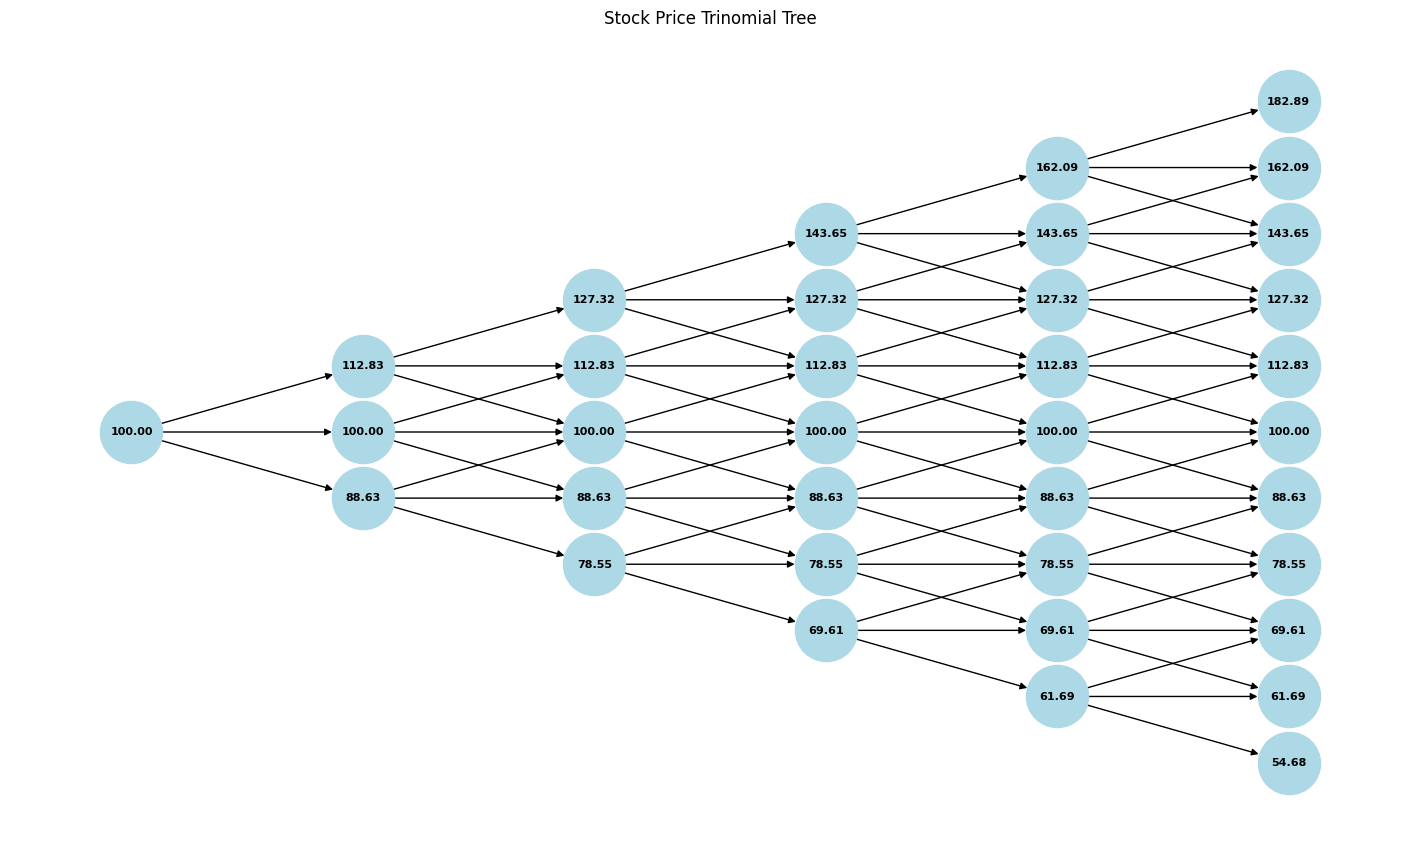

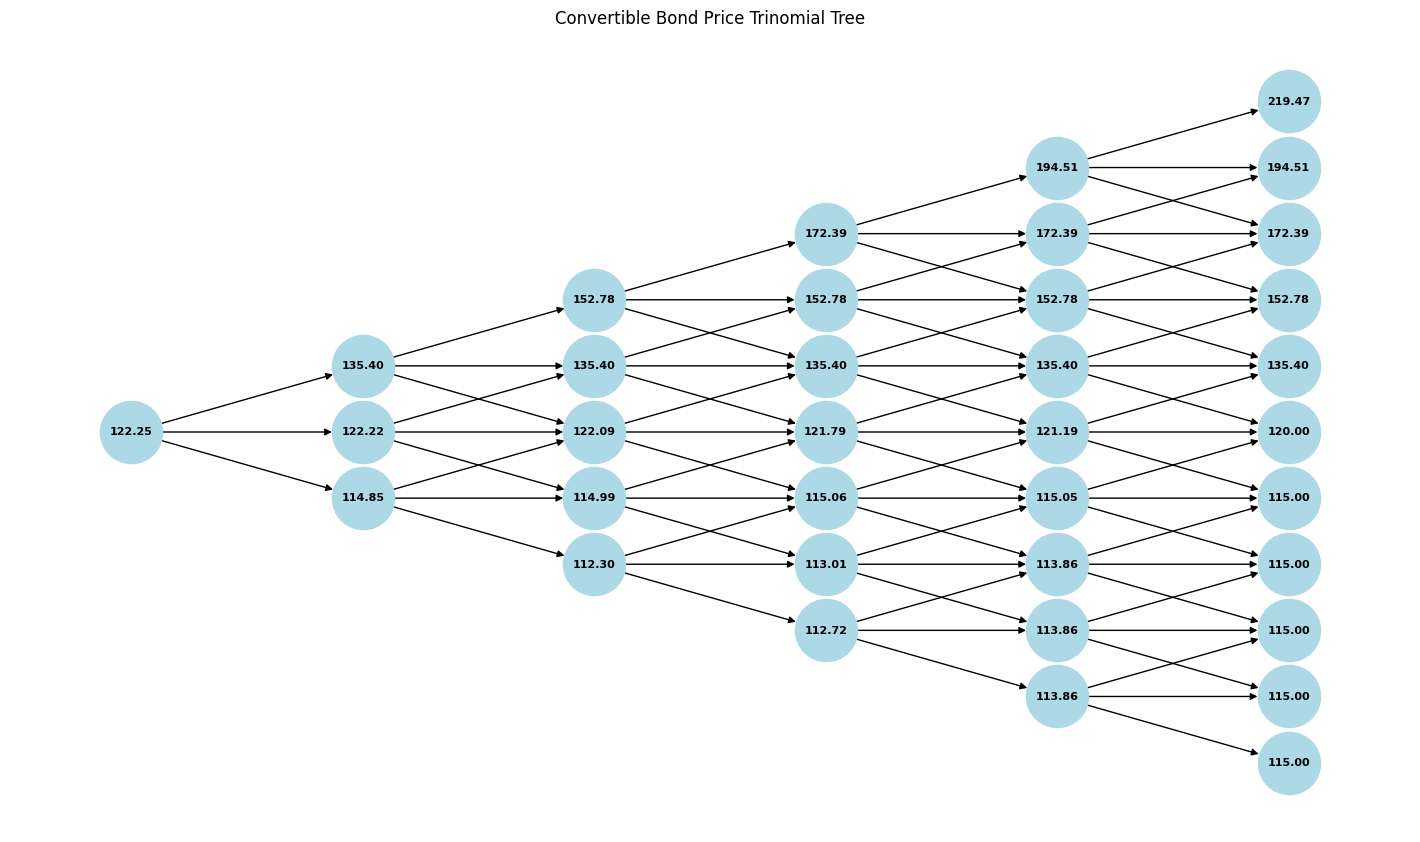

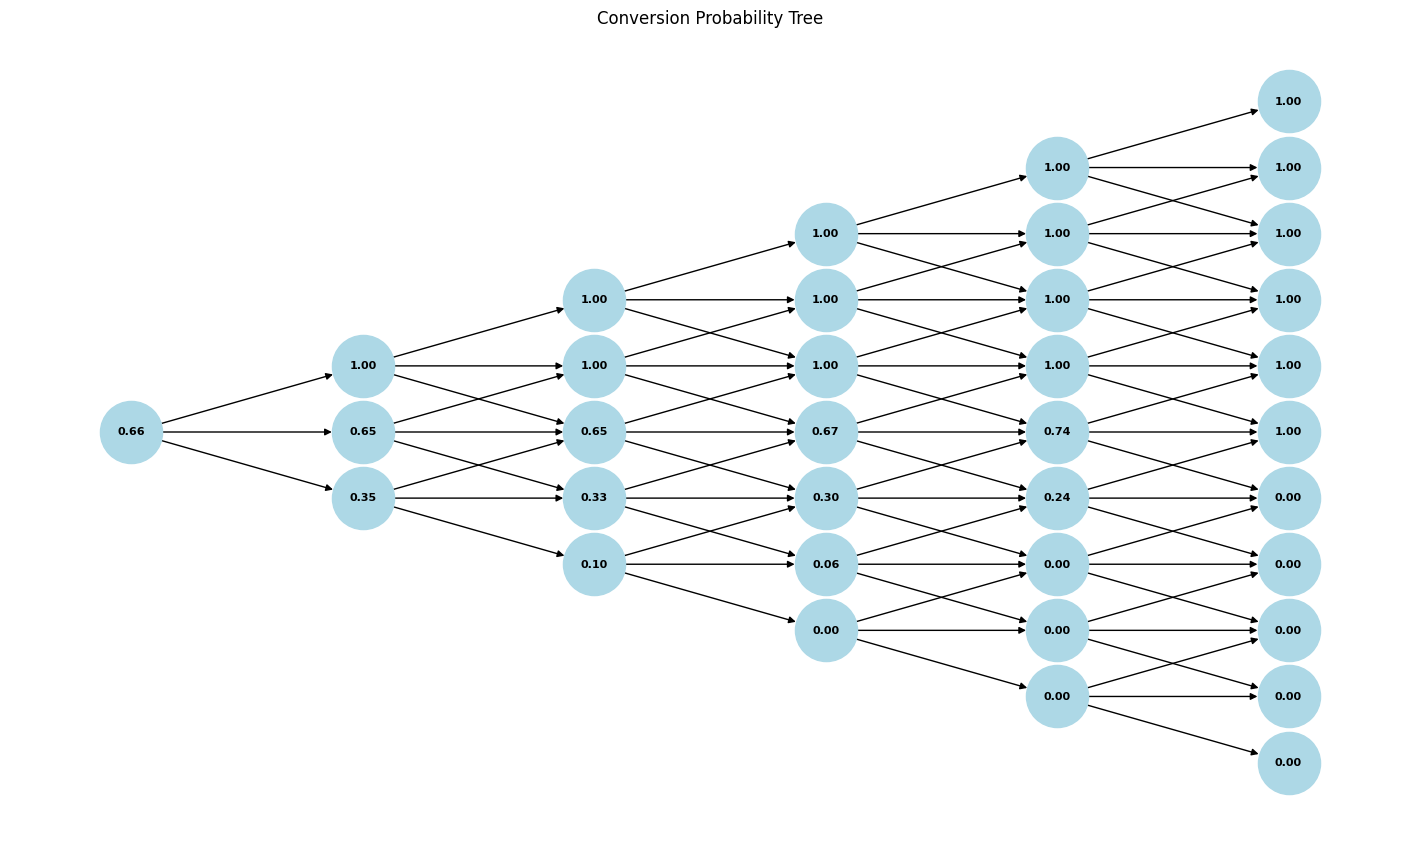

In [4]:
def plot_trinomial_tree(tree, title):
    steps = tree.shape[1] - 1
    G = nx.DiGraph()

    pos = {}
    labels = {}

    # Define the horizontal offset to center the nodes at each level
    for i in range(steps + 1):
        for j in range(2 * i + 1):
            node = f"{i},{j}"
            G.add_node(node)
            pos[node] = (i, j - i)  # Adjust for better layout
            labels[node] = f"{tree[j, i]:.2f}"

            if i < steps:
                G.add_edge(node, f"{i+1},{j}")      # Down
                G.add_edge(node, f"{i+1},{j+1}")    # Middle
                G.add_edge(node, f"{i+1},{j+2}")    # Up

    # Plot
    plt.figure(figsize=(14, 8))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=2000,
            node_color="lightblue", font_size=8, font_weight="bold", edge_color="black")
    plt.title(title)
    plt.show()

# Calculate the trinomial trees
StockPrice, BondPrice, ConversionProbability = TrinomialConvBond(S0, F, T, r, k, coupon, conversion_ratio, N, sigma, AmeEur='a')

# Plot the stock price tree
plot_trinomial_tree(StockPrice, "Stock Price Trinomial Tree")

# Plot the bond price tree
plot_trinomial_tree(BondPrice, "Convertible Bond Price Trinomial Tree")

# Plot the conversion probability tree
plot_trinomial_tree(ConversionProbability, "Conversion Probability Tree")


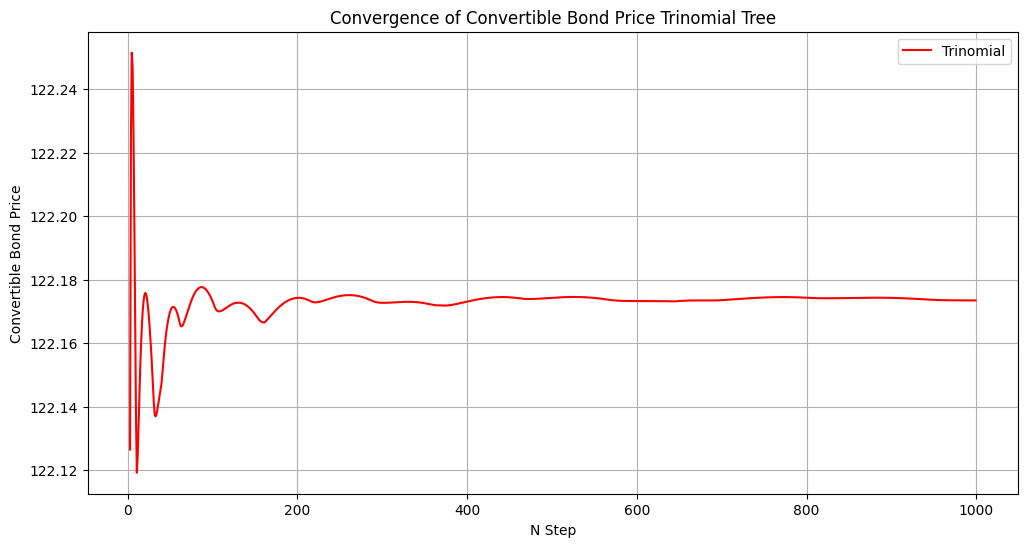

In [ ]:
def getPrice(S0, F, T, r, k, coupon, conversion_ratio, N, model):
    if model == 'Trinomial':
        StockPrice, BondPrice, ConversionProbability = TrinomialConvBond(S0, F, T, r, k, coupon, conversion_ratio, N, sigma, AmeEur='a')
        return BondPrice[0, 0]  # Return the bond price

# Input parameters for the bond
S0 = 100                # Initial stock price
F = 110                 # Face value of the bond
T = 0.5                 # Time to maturity
r = 0.1                 # Risk-free rate
k = 0.02                # Spread over risk-free rate
coupon = 5              # Annual coupon payment
conversion_ratio = 1.2  # Conversion ratio
sigma = 0.27            # Volatility
AmeEur = 'a'            # 'a' for American, 'e' for European
min_step = 3            # Minimum number of steps in the tree
max_step = 1000         # Maximum number of steps in the tree

# Define the list of models to include in the plot
model_types = ['Trinomial']

# Initialize a dictionary to store the bond prices for each model
results = {model: np.zeros([max_step - min_step]) for model in model_types}

# Loop through each model and calculate the bond price for varying steps
for model in model_types:
    j = 0
    for i in np.arange(min_step, max_step):
        results[model][j] = getPrice(S0, F, T, r, k, coupon, conversion_ratio, i, model)
        j += 1

# Create a plot for convergence
plt.figure(figsize=(12, 6))

# Define a color scheme for each model
colors = {'Trinomial': 'red'}

# Plot each model with its respective color and label
for model in model_types:
    plt.plot(range(min_step, max_step), results[model], label=model, color=colors[model])

# Add labels and title
plt.xlabel("N Step")
plt.ylabel("Convertible Bond Price")
plt.title("Convergence of Convertible Bond Price Trinomial Tree")
plt.grid(True)
plt.legend()
plt.show()

In [11]:
from scipy.stats import norm

In [27]:
S = 100            # Initial stock price
X = 110            # Strike price
T = 0.5            # Time to maturity (in years)
b = r = 0.1        # Cost of carry
sigma = 0.27       # Volatility
N = 30             # Number of time steps
AmeEur = 'a'       # 'a' for American, 'e' for European

# Black-Scholes function
def black_scholes(S, b, r, T, sigma, option_type = 'call'):
    d1 = (np.log(S/X) + (b + (sigma**2 / 2)) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        BSM = S * np.exp((b - r) * T) * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        BSM = X * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp((b - r) * T) * norm.cdf(-d1)
    return BSM

black_scholes(S0, b, r, T, sigma, option_type = 'call')

5.68104944672266

In [ ]:
# Trinomial tree for option pricing
def trinomial_option_pricing(S0, K, T, r, b, sigma, N, option_type='call', AmeEur='e'):
    dt = T / N
    u = np.exp(sigma * np.sqrt(2 * dt))
    d = np.exp(-sigma * np.sqrt(2 * dt))
    pu = ((np.exp(b * dt / 2) - d) / (u - d)) ** 2
    pd = ((u - np.exp(b * dt / 2)) / (u - d)) ** 2
    pm = 1 - pu - pd
    Df = np.exp(-r * dt)

    OptionValue = np.zeros((2 * N + 1, N + 1))
    StockPrice = np.zeros((2 * N + 1, N + 1))

    # Calculate stock prices at maturity
    for i in range(N + 1):
        for j in range(2 * i + 1):
            StockPrice[j, i] = S0 * (u ** max(0, j - i)) * (d ** max(0, i - j))

    # Terminal option values
    for j in range(2 * N + 1):
        if option_type == 'call':
            OptionValue[j, N] = max(0, StockPrice[j, N] - K)
        elif option_type == 'put':
            OptionValue[j, N] = max(0, K - StockPrice[j, N])

    # Backward induction
    for i in range(N - 1, -1, -1):
        for j in range(2 * i + 1):
            continuation_value = (pu * OptionValue[j + 2, i + 1] +
                                  pm * OptionValue[j + 1, i + 1] +
                                  pd * OptionValue[j, i + 1]) * Df
            if AmeEur == 'a':  # American option: consider early exercise
                if option_type == 'call':
                    OptionValue[j, i] = max(continuation_value, StockPrice[j, i] - K)
                elif option_type == 'put':
                    OptionValue[j, i] = max(continuation_value, K - StockPrice[j, i])
            else:  # European option
                OptionValue[j, i] = continuation_value

    return OptionValue[0, 0]
